# Generate synthetic MT soundings

## Goals

- Use random number generator to determine number N of data points
- Produce logarithmic Gaussian distribution for resistivities (0.1 to 10000 Ohms)
- Draw N samples from this Gaussian distribution
- Select N number of depths to be associated with the resistivity values from a uniform distribution of 0 to 15 km
- Use cubic spline interpolation on a 51-point grid to generate synthetics

In [1]:
#Import required packages

import numpy as np
from SimPEG.electromagnetics import natural_source as nsem
from SimPEG import maps
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from SimPEG.utils import plot_1d_layer_model
from discretize import TensorMesh
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
matplotlib.rcParams['font.size'] = 14
import torch
import random
import normflows as nf
import scipy
from scipy.stats import truncnorm
from scipy.interpolate import CubicSpline, PchipInterpolator

In [2]:
#Forward modelling function from SimPEG

def run_forward(layer_thicknesses, rho_layers, frequencies, relative_error_rho=0.05, floor_phase=2):
    mesh = TensorMesh([(np.r_[layer_thicknesses, layer_thicknesses[-1]])], "N")

    wire_map = maps.Wires(("sigma", mesh.nC), ("t", mesh.nC - 1))
    sigma_map = maps.ExpMap(nP=mesh.nC) * wire_map.sigma
    layer_map = maps.ExpMap(nP=mesh.nC - 1) * wire_map.t


    sigma_map = maps.ExpMap(nP=len(rho_layers))

    receivers_list = [
        nsem.receivers.PointNaturalSource(component="app_res"),
        nsem.receivers.PointNaturalSource(component="phase"),
    ]

    source_list = []
    for freq in frequencies:
        source_list.append(nsem.sources.Planewave(receivers_list, freq))

    survey = nsem.survey.Survey(source_list)

    simulation = nsem.simulation_1d.Simulation1DRecursive(
        survey=survey, 
        sigmaMap=sigma_map,
        thicknesses=layer_thicknesses,
    )

    true_model = np.r_[np.log(1./rho_layers)]

    dpred = simulation.dpred(true_model)
    rho_app = dpred.reshape((len(frequencies), 2))[:,0]
    phase = dpred.reshape((len(frequencies), 2))[:,1]
    std = np.c_[abs(rho_app)*relative_error_rho, np.ones(len(phase))*floor_phase].flatten()
    noise = np.c_[np.random.randn(rho_app.size)*relative_error_rho*abs(rho_app), np.random.randn(rho_app.size)*floor_phase].flatten()
    dobs = dpred + noise
    return dobs

In [3]:
#Select number of samples between 3 and 15. (Had to use 2 instead of 1 to agree with SimPEG forward function)

num_samples = random.randint(3,15)
print(num_samples)

11


In [4]:
#Sample num_samples number of depths between 0 and 15,000 m
depths = np.random.uniform(0,15000,num_samples)
depth_len = len(depths)
#depths = np.insert(depths, 0, 0)
#depths = np.append(depths,16000)
depth_one = depths[0]
print(depth_one)

2586.6487133596115


In [5]:
#num_samples = num_samples + 1
print(num_samples)

11


In [6]:
#Define Gaussian distribution
    
mu, sigma = 1, 1.5 #mean and std deviation of the Gaussian distribution
samples = np.random.normal(mu, sigma, num_samples) #sample the distribution

#Apply bounds to the samples of -1 and 4

samples[samples < -1] = -1
samples[samples > 4] = 4

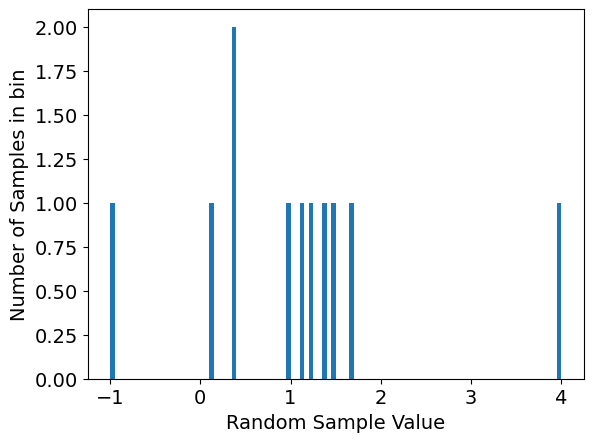

In [7]:
#Plot sampled distribution

count, bins, ignored = plt.hist(samples, 100, density=False)
plt.xlabel('Random Sample Value')
plt.ylabel('Number of Samples in bin')
#plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               #np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         #linewidth=2, color='r')
plt.show()

In [8]:
print(samples)

[ 0.9962481   0.35024145 -1.          1.65096009  0.128962    1.1395456
  1.21506043  1.46032692  4.          0.37977451  1.36275465]


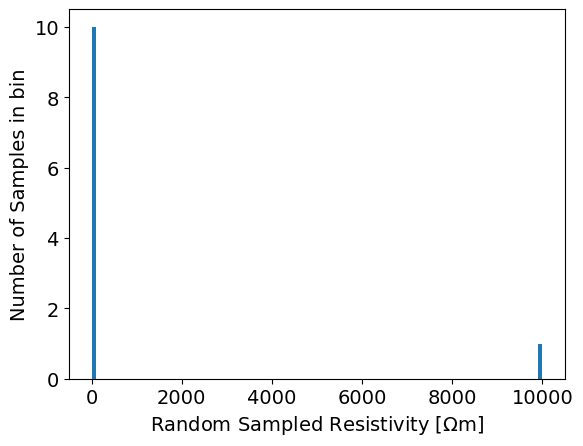

In [9]:
#Convert the samples to a logarithmic scale [10^(samples)]

samples_to_the_power_of_10 = np.power(10,samples)
count, bins, ignored = plt.hist(samples_to_the_power_of_10, 100, density=False)
plt.xlabel('Random Sampled Resistivity [$\Omega$m]')
plt.ylabel('Number of Samples in bin')
plt.show()

In [10]:
#Sampled resistivities

print(samples_to_the_power_of_10)

[9.91398131e+00 2.23996612e+00 1.00000000e-01 4.47672162e+01
 1.34574259e+00 1.37894074e+01 1.64081806e+01 2.88620328e+01
 1.00000000e+04 2.39758774e+00 2.30544441e+01]


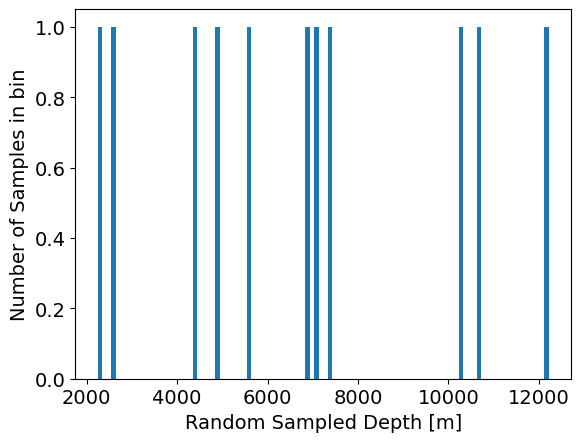

In [11]:
#Display depths sampled

count, bins, ignored = plt.hist(depths, 100, density=False)
plt.xlabel('Random Sampled Depth [m]')
plt.ylabel('Number of Samples in bin')
#plt.plot(bins, np.ones_like(bins), linewidth=2, color='r')
plt.show()

In [12]:
#Sort depths in order and then multiply by -1 to agree with SimPEG depth convention

depths = np.sort(depths)

In [13]:
#Sampled depths

depths = -depths
print(depths)

[ -2246.79519937  -2586.64871336  -4391.45472291  -4900.82029225
  -5560.49007305  -6888.48688603  -7037.67344533  -7364.19769854
 -10300.94578397 -10665.88266869 -12216.46034132]


In [14]:
#Calculate layer properties

layer_tops = np.r_[depths][::-1]  # in m
layer_thicknesses = np.diff(layer_tops)
rho_layers = np.r_[samples_to_the_power_of_10][::-1]
print(layer_thicknesses)

[1550.57767263  364.93688472 2936.74808543  326.52425322  149.1865593
 1327.99681298  659.66978079  509.36556934 1804.80600955  339.85351399]


In [15]:
#Setting frequencies to 28 and generating synthetic dobs

frequencies = np.logspace(-3, 3, 28)
relative_error_rho = 0.05
floor_phase = 2.
dobs = run_forward(layer_thicknesses, rho_layers, frequencies, relative_error_rho=relative_error_rho, floor_phase=floor_phase)

In [16]:
#Check dobs shape

dobs.shape

(56,)

In [17]:
#Check apparent resistivities and phases

print(dobs)

[ 1.71888568 17.63839288  1.11365517 22.38416392  0.80079173 28.82281253
  0.72865488 35.5203466   0.62899875 50.35788692  0.83084223 56.06806549
  1.02641471 62.22891779  1.29606333 72.06208172  1.99245553 71.05545543
  2.96019596 61.8914036   3.31021028 59.67435766  4.0610473  55.83268529
  3.90102494 51.95092657  3.77665587 53.71794023  4.77183215 56.89970473
  5.2854841  55.92859933  6.28884654 55.78103224  7.54584729 54.5462241
  9.43756186 53.90422886 10.66042267 53.09666469 10.31434899 47.67359766
 10.26976307 50.33516383  9.94053141 49.79639348  9.52547476 40.98489521
 10.40067942 47.48182788 10.83744025 43.1818233   9.30623222 46.44697615
 10.20493673 44.51096335]


In [18]:
#Print layer boundaries and thicknesses

print(layer_tops)
print(layer_thicknesses)

[-12216.46034132 -10665.88266869 -10300.94578397  -7364.19769854
  -7037.67344533  -6888.48688603  -5560.49007305  -4900.82029225
  -4391.45472291  -2586.64871336  -2246.79519937]
[1550.57767263  364.93688472 2936.74808543  326.52425322  149.1865593
 1327.99681298  659.66978079  509.36556934 1804.80600955  339.85351399]


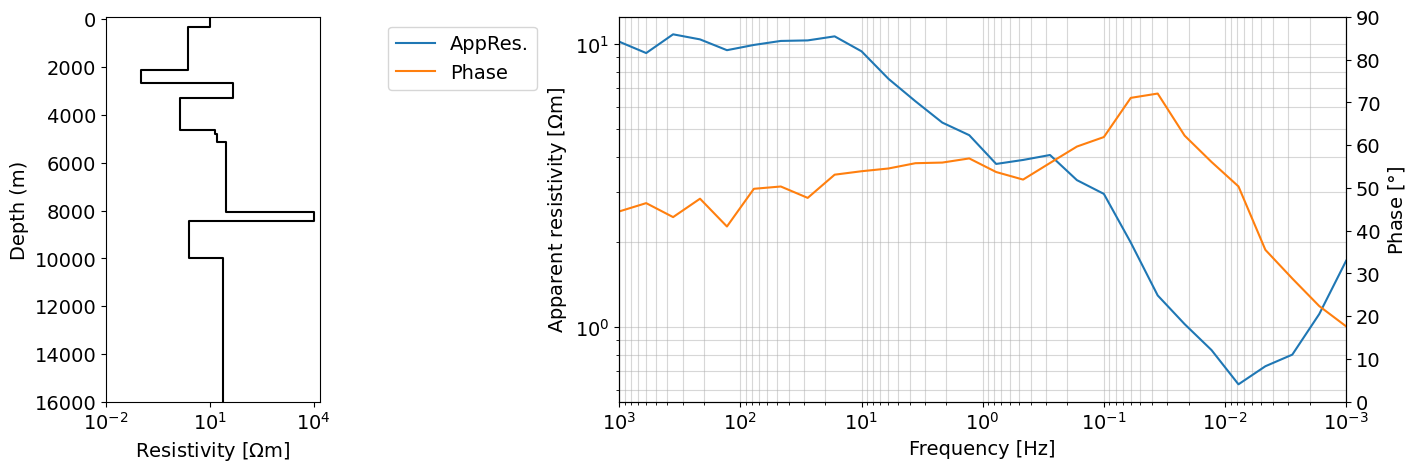

In [19]:
#Display resistivity-depth model and forward modelled phase and apparent resistivities (pulled from SimPEG tutorial)

fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(1, 5, figure=fig)
ax0 = fig.add_subplot(gs[0, 0])
plot_1d_layer_model(layer_thicknesses[::-1], rho_layers[::-1], ax=ax0, color="k", **{'label':'True'})
ax0.set_xlabel("Resistivity [$\Omega$m]")
ax0.set_xlim(0.01, 15000)
ax0.set_ylim(16000,-100)
# ax0.set_yscale('log')
ax = fig.add_subplot(gs[0, 2:])
ax.loglog(frequencies, dobs.reshape((len(frequencies), 2))[:,0], color='C0', label='AppRes.')
ax.loglog(frequencies[0], dobs.reshape((len(frequencies), 2))[0,0], color='C1', label='Phase')
ax_1 = ax.twinx()
ax_1.plot(frequencies, dobs.reshape((len(frequencies), 2))[:,1], color='C1')
ax.set_xlabel("Frequency [Hz]") 
ax_1.set_ylim(0, 90)    
ax.grid(True, which='both', alpha=0.5)
ax.set_ylabel("Apparent resistivity [$\Omega$m]")
ax_1.set_ylabel("Phase [$\degree$]")
ax.legend(bbox_to_anchor=(-0.1, 1))
#ax.set_xlim(100000,0.0001)
ax.set_xlim(frequencies.max(), frequencies.min())
plt.show()

In [20]:
#Check depths and resistivities from the blocky resistivity model

print(depths)
print(samples_to_the_power_of_10)

[ -2246.79519937  -2586.64871336  -4391.45472291  -4900.82029225
  -5560.49007305  -6888.48688603  -7037.67344533  -7364.19769854
 -10300.94578397 -10665.88266869 -12216.46034132]
[9.91398131e+00 2.23996612e+00 1.00000000e-01 4.47672162e+01
 1.34574259e+00 1.37894074e+01 1.64081806e+01 2.88620328e+01
 1.00000000e+04 2.39758774e+00 2.30544441e+01]


In [23]:
#Create array called inter_depths for the sample depths for the interpolation step. Adjust these inter_depths to be at the midpoint of the layers in the blocky resistivity model

print("Depths before changes for interpolation:")
print(depths)
inter_depths = np.zeros(num_samples)
depth_len = len(depths)
inter_depths[0] = depths[0]/2 #First layer boundary is at half of the depth to sample the middle of the first layer and reduce extrapolation between surface
for x in range(depth_len-1):  #Iterate through the elements of depths (except the last one)
    inter_depths[x+1] = (depths[x+1] + depths[x]) / 2   #Interpolate at the midpoints of layers
inter_depths[depth_len-1] = -16000  #Final layer is at 16000m, creating halfspace effect from 0 to 15000m
print("Depths after changes for interpolation:")
print(inter_depths)

Depths before changes for interpolation:
[ -2246.79519937  -2586.64871336  -4391.45472291  -4900.82029225
  -5560.49007305  -6888.48688603  -7037.67344533  -7364.19769854
 -10300.94578397 -10665.88266869 -12216.46034132]
Depths after changes for interpolation:
[ -1123.39759969  -2416.72195637  -3489.05171813  -4646.13750758
  -5230.65518265  -6224.48847954  -6963.08016568  -7200.93557193
  -8832.57174125 -10483.41422633 -16000.        ]


In [38]:
#Make depths positive to agree with SciPy spline convention

depths = -depths
inter_depths = -inter_depths
print(depths)
print(inter_depths)

[ 2246.79519937  2586.64871336  4391.45472291  4900.82029225
  5560.49007305  6888.48688603  7037.67344533  7364.19769854
 10300.94578397 10665.88266869 12216.46034132]
[ 1123.39759969  2416.72195637  3489.05171813  4646.13750758
  5230.65518265  6224.48847954  6963.08016568  7200.93557193
  8832.57174125 10483.41422633 16000.        ]


In [25]:
#Check resistivity samples

print(samples_to_the_power_of_10)

[9.91398131e+00 2.23996612e+00 1.00000000e-01 4.47672162e+01
 1.34574259e+00 1.37894074e+01 1.64081806e+01 2.88620328e+01
 1.00000000e+04 2.39758774e+00 2.30544441e+01]


In [26]:
#Created 51 layer model with starting thickness of 72.45875m and increasing by 5% at each layer
dz = 72.45875
n_layer = 53
z_factor = 1.05
knots = dz*z_factor**np.arange(n_layer-2)[::1]
knots = np.cumsum(knots)
knots = np.insert(knots, 0, 0)
print(knots)

[    0.            72.45875      148.5404375    228.42620937
   312.30626984   400.38033334   492.8581       589.959755
   691.91649275   798.97106739   911.37837076  1029.4060393
  1153.33509126  1283.46059583  1420.09237562  1563.5557444
  1714.19228162  1872.3606457   2038.43742798  2212.81804938
  2395.91770185  2588.17233695  2790.03970379  3002.00043898
  3224.55921093  3458.24592148  3703.61696755  3961.25656593
  4231.77814423  4515.82580144  4814.07584151  5127.23838358
  5456.05905276  5801.3207554   6163.84554317  6544.49657033
  6944.18014885  7363.84790629  7804.4990516   8267.18275418
  8753.00064189  9263.10942399  9798.72364519 10361.11857745
 10951.63325632 11571.67366913 12222.71610259 12906.31065772
 13624.08494061 14377.74793764 15169.09408452 16000.00753875]


In [27]:
#Implemented both cubic splines and monotonic cubic splines to interpolate the resisitivity-depth model. I prefer monotonic cubic splines to avoid overshooting

cs = CubicSpline(inter_depths, samples)
mono = PchipInterpolator(inter_depths, samples)

#Evaluate the spline functions at the knots values

values = cs(knots)
mono_vals = mono(knots)

In [29]:
#Resisitivity values at each layer boundary for cubic splines

print(values)

[-1.14574271e+01 -1.00602850e+01 -8.69554571e+00 -7.37166259e+00
 -6.09763697e+00 -4.88296776e+00 -3.73757628e+00 -2.67170048e+00
 -1.69575183e+00 -8.20126417e-01 -5.49608756e-02  5.90178650e-01
  1.10668799e+00  1.48741303e+00  1.72725335e+00  1.82390390e+00
  1.77876088e+00  1.59802310e+00  1.29402492e+00  8.86843773e-01
  4.06232208e-01 -1.06066687e-01 -5.93551744e-01 -9.81663529e-01
 -1.17385735e+00 -1.04693942e+00 -4.88341870e-01  3.68195650e-01
  1.22815817e+00  1.69728697e+00  1.30668124e+00  3.57203080e-01
 -5.66000886e-03  4.38389888e-01  1.07257432e+00  1.22173940e+00
  1.20517654e+00  1.71245523e+00  2.55741051e+00  3.43772561e+00
  3.97665545e+00  3.74687012e+00  2.66476179e+00  8.43679140e-01
 -1.54264293e+00 -4.24591357e+00 -6.92582788e+00 -9.12922854e+00
 -1.02652877e+01 -9.57600849e+00 -6.10122679e+00  1.36284259e+00]


In [30]:
#Resisitivity values at each layer boundary for monotonic cubic splines

print(mono_vals)

[ 0.33944951  0.4362305   0.52852437  0.61547381  0.69616464  0.76962961
  0.83485424  0.89078535  0.93634282  0.97043525  0.99198049  0.99993194
  0.99331187  0.97125317  0.9330512   0.87822767  0.80660893  0.71842133
  0.61440694  0.49596332  0.36531171  0.16999648 -0.14176921 -0.50492126
 -0.829719   -0.99734418 -0.76033611 -0.0358459   0.87456609  1.55766384
  1.34624221  0.25503291  0.25427238  0.72099235  1.11916547  1.17114921
  1.21111642  1.68711375  2.52875154  3.44768682  3.98682801  3.38973492
  1.7314485   0.43643382  0.38037552  0.38732076  0.41058216  0.46305402
  0.56115929  0.72558098  0.98212804  1.36275868]


In [31]:
#Interpolation layer boundary depths

print(knots)

[    0.            72.45875      148.5404375    228.42620937
   312.30626984   400.38033334   492.8581       589.959755
   691.91649275   798.97106739   911.37837076  1029.4060393
  1153.33509126  1283.46059583  1420.09237562  1563.5557444
  1714.19228162  1872.3606457   2038.43742798  2212.81804938
  2395.91770185  2588.17233695  2790.03970379  3002.00043898
  3224.55921093  3458.24592148  3703.61696755  3961.25656593
  4231.77814423  4515.82580144  4814.07584151  5127.23838358
  5456.05905276  5801.3207554   6163.84554317  6544.49657033
  6944.18014885  7363.84790629  7804.4990516   8267.18275418
  8753.00064189  9263.10942399  9798.72364519 10361.11857745
 10951.63325632 11571.67366913 12222.71610259 12906.31065772
 13624.08494061 14377.74793764 15169.09408452 16000.00753875]


In [32]:
#Log10(resistivity) samples at the interpolation depths
print(samples)

[ 0.9962481   0.35024145 -1.          1.65096009  0.128962    1.1395456
  1.21506043  1.46032692  4.          0.37977451  1.36275465]


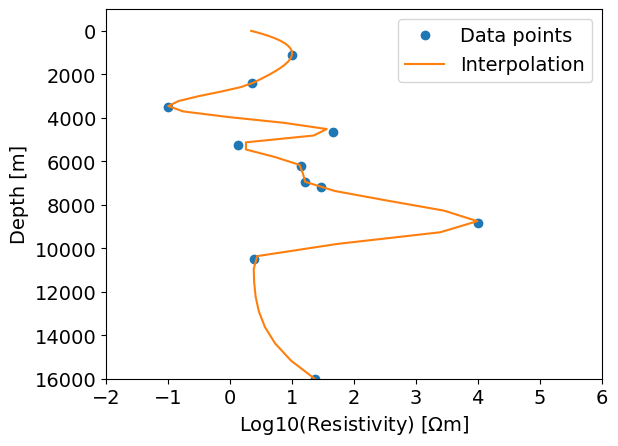

In [33]:
#Plot interpolated log10(resistivity) model

plt.figure()
plt.plot(samples,inter_depths, 'o', label='Data points')
#plt.plot(values,knots, '-')
plt.plot(mono_vals,knots, '-', label='Interpolation')
plt.legend()
plt.xlabel('Log10(Resistivity) [$\Omega$m]')
#plt.xscale("log")
plt.ylabel('Depth [m]')
plt.ylim(16000,-1000)
plt.xlim(-2, 6)
plt.show()

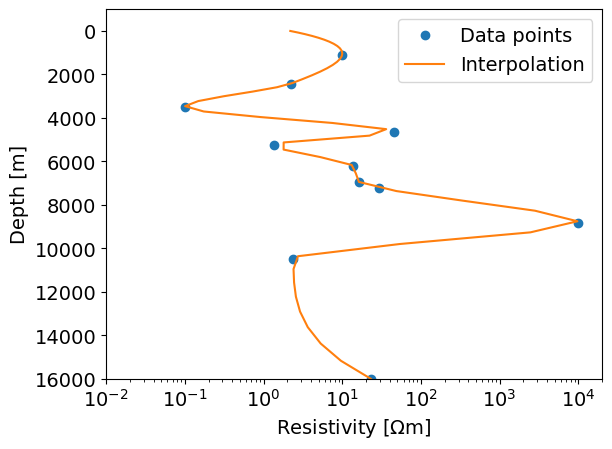

In [34]:
#Plot interpolated resistivity model

mono_vals_to_the_power_of_10 = np.power(10,mono_vals)
plt.figure()
plt.plot(samples_to_the_power_of_10,inter_depths, 'o', label='Data points')
#plt.plot(values,knots, '-')
plt.plot(mono_vals_to_the_power_of_10,knots, '-', label='Interpolation')
plt.legend()
plt.xlabel('Resistivity [$\Omega$m]')
plt.xscale("log")
plt.ylabel('Depth [m]')
plt.ylim(16000,-1000)
plt.xlim(0.01, 20000)
plt.show()

In [35]:
size = len(knots)
print(size)

52
